# Customer Lifetime Value (CLV) Prediction

**Project Overview**
* Customer Lifetime Value (CLV) is a key business metric that estimates the future revenue a customer is expected to generate. Accurately predicting CLV enables businesses to optimize marketing spend, improve customer retention, and prioritize high-value customers.

* In this project, I built an end-to-end CLV prediction system using transactional e-commerce data, applying RFM-based feature engineering, leakage-free target construction, and machine learning regression models. The final model leverages Random Forest regression and SHAP explainability to deliver both high predictive accuracy and actionable business insights.
---

**Business Problem**
* The objective is to predict each customer’s **future 6-month revenue** based on historical purchase behavior, enabling data-driven customer segmentation and targeted marketing strategies.
---

### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


| Column      | Meaning             |
| ----------- | ------------------- |
| Invoice     | Transaction ID      |
| StockCode   | Product ID          |
| Description | Product name        |
| Quantity    | Units bought        |
| InvoiceDate | Purchase time       |
|     Price   | Price per unit      |
| Customer ID | Customer identifier |
| Country     | Customer country    |

In [4]:
df.shape

(1067371, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [7]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [8]:
df.describe(include='O').T

,count,unique,top,freq
Invoice,1067371,53628,537434,1350
StockCode,1067371,5305,85123A,5829
Description,1062989,5698,WHITE HANGING HEART T-LIGHT HOLDER,5918
InvoiceDate,1067371,47635,2010-12-06 16:57:00,1350
Country,1067371,43,United Kingdom,981330


### EDA

**Missing Values Analysis**

In [9]:
missing = df.isnull().sum()
missing[missing > 0]

Description      4382
Customer ID    243007
dtype: int64

In [10]:
(missing / len(df) * 100).round(2)

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

**Invalid Transactions**

In [11]:
df[df['Quantity'] <= 0].shape

(22950, 8)

In [12]:
df[df['Price'] <= 0].shape

(6207, 8)

Negative quantities represent returns and cancellations, which were excluded from CLV calculation

**Transaction Date Analysis**

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

**Transactions Over Time**

<Axes: title={'center': 'Monthly Revenue Trend'}, xlabel='InvoiceDate'>

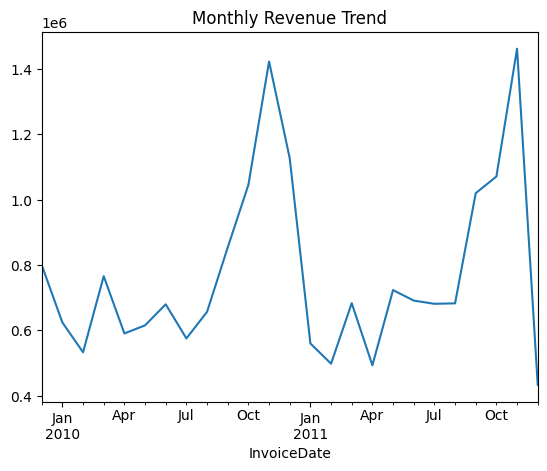

In [15]:
monthly_revenue = (
    df.assign(Revenue=df['Quantity'] * df['Price'])
      .groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Revenue']
      .sum()
)

monthly_revenue.plot(title="Monthly Revenue Trend")

**Country-wise Distribution**

In [16]:
df['Country'].value_counts().head(10)

Country
United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Spain               3811
Switzerland         3189
Belgium             3123
Portugal            2620
Australia           1913
Name: count, dtype: int64

In [17]:
df['Country'].value_counts(normalize=True).head(5) * 100

Country
United Kingdom    91.938979
EIRE               1.673832
Germany            1.651160
France             1.342551
Netherlands        0.481557
Name: proportion, dtype: float64

**Customer-Level Aggregation**

In [18]:
df['TotalPrice'] = df['Quantity'] * df['Price']

customer_txn = df.groupby('Customer ID').agg({
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

customer_txn.describe()

,Customer ID,Invoice,TotalPrice
count,5942.000000,5942.000000,5942.000000
mean,15316.500000,7.552339,2801.799459
std,1715.451981,15.972262,13973.922553
min,12346.000000,1.000000,-25111.090000
25%,13831.250000,2.000000,325.097500
50%,15316.500000,4.000000,843.970000
75%,16801.750000,8.000000,2182.005000
max,18287.000000,510.000000,598215.220000


Highly skewed monetary distribution and Few customers contribute most revenue

**Distribution of Monetary Value**

In [19]:
customer_txn['TotalPrice'].describe(percentiles=[0.9, 0.95, 0.99])

count      5942.000000
mean       2801.799459
std       13973.922553
min      -25111.090000
50%         843.970000
90%        5257.358000
95%        9087.290000
99%       26484.144600
max      598215.220000
Name: TotalPrice, dtype: float64

<Axes: >

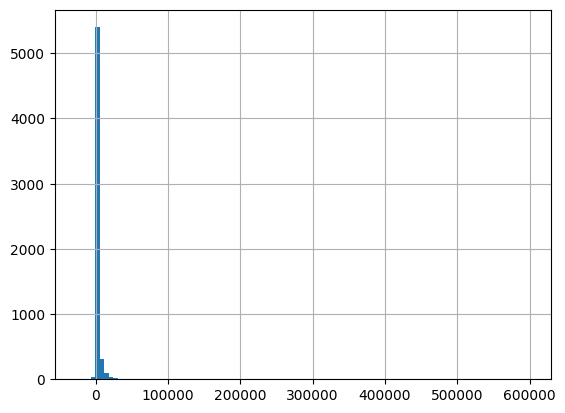

In [20]:
customer_txn['TotalPrice'].hist(bins=100)

Long-tailed distribution and log-transform for CLV is required

### Data Cleaning

#### Rename Columns

In [21]:
df = df.rename(columns={
    'Customer ID': 'CustomerID',
    'InvoiceDate': 'InvoiceDate',
    'Price': 'UnitPrice'
})

In [22]:
#### Convert Date Column

In [23]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#### Handle Missing CustomerID

In [24]:
# rows without CustomerID are useless - hence they are removed

df = df[df['CustomerID'].notna()]

#### Handle Cancellations

In [25]:
df[df['Invoice'].str.lower().str.startswith('c', na=False)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.4
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,-9.9
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,-17.0
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,-12.6
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,-35.4


In [26]:
# Remove negative quantities
df = df[df['Quantity'] > 0]

# Remove invoices starting with 'C'
df = df[~df['Invoice'].astype(str).str.startswith('C')]  # Select all rows where InvoiceNo does NOT start with ‘C’”

#### Remove Invalid Prices
Negative prices → negative revenue → completely breaks CLV

In [27]:
df = df[df['UnitPrice'] > 0]

#### Create Revenue Column
This is the target signal

In [28]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

#### Post-Cleaning Sanity Checks

In [29]:
df.shape

(805549, 9)

In [30]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,805549.000000,805549,805549.000000,805549.000000,805549.000000
mean,13.290522,2011-01-02 10:24:44.106814464,3.206561,15331.954970,22.026505
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000,0.001000
25%,2.000000,2010-07-07 12:08:00,1.250000,13982.000000,4.950000
50%,5.000000,2010-12-03 15:10:00,1.950000,15271.000000,11.850000
75%,12.000000,2011-07-28 13:05:00,3.750000,16805.000000,19.500000
max,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000,168469.600000
std,143.634088,NaN,29.199173,1696.737039,224.041928


In [31]:
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,805549,805549,805549,805549
unique,36969,4631,5283,41
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,542,5188,5181,725250


In [32]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [33]:
df['CustomerID'].nunique()

5878

In [34]:
df['TotalPrice'].describe(percentiles=[0.9, 0.95, 0.99])

count    805549.000000
mean         22.026505
std         224.041928
min           0.001000
50%          11.850000
90%          35.400000
95%          67.500000
99%         201.600000
max      168469.600000
Name: TotalPrice, dtype: float64

CLV data is heavily right-skewed; a small fraction of customers drive most revenue

In [35]:
#### Save Clean Transaction Data
df.to_csv("clean_transactions.csv", index=False)

### Feature Engineering

#### Set the Snapshot Date
* All CLV features depend on a fixed reference date
* Used a snapshot date to ensure recency is calculated consistently and without leakage
* selected a snapshot date 6 months before the dataset end to ensure future purchase data for CLV labeling

In [36]:
end_date = df['InvoiceDate'].max()

snapshot_date = end_date - pd.DateOffset(months=6)

In [37]:
snapshot_date

Timestamp('2011-06-09 12:50:00')

### Create CLV Target (Future 6-Month Revenue)

#### Define Time Cutoff

In [38]:
clv_horizon = snapshot_date + pd.DateOffset(months=6)

#### Split Past vs Future Transactions

In [39]:
# Past (for features)

past_df = df[df['InvoiceDate'] < snapshot_date]

In [40]:
# Future (for target)

future_df = df[
    (df['InvoiceDate'] >= snapshot_date) &
    (df['InvoiceDate'] < clv_horizon)
]

#### Create Basic RFM Table

compute RFM Using past data only - features must come ONLY from pas

* RFM stands for **Recency, Frequency, and Monetary Value**.
* It is a marketing tool used to analyze customer behavior by categorizing customers based on three key factors:
    * **Recency**: How recently a customer made a purchase.
    * **Frequency**: How often a customer makes purchases.
    * **Monetary Value**: The total amount spent by a customer.
* RFM analysis helps businesses identify their most valuable customers and tailor marketing strategies accordingly, ultimately increasing customer loyalty and sales

In [41]:
rfm = past_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [42]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4967.000000,4967.000000,4967.00000,4967.000000
mean,15339.708275,171.028186,5.29092,2484.451243
std,1704.016051,145.209900,10.24505,11043.523323
min,12346.000000,0.000000,1.00000,2.900000
25%,13879.500000,37.000000,1.00000,319.195000
50%,15333.000000,147.000000,3.00000,780.050000
75%,16816.500000,249.000000,6.00000,2011.910000
max,18287.000000,555.000000,262.00000,424805.980000


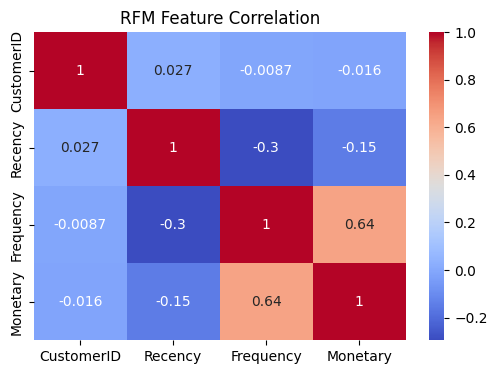

In [43]:
# Correlation Analysis
    
plt.figure(figsize=(6,4))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm')
plt.title("RFM Feature Correlation")
plt.show()

In [44]:
# Average Order Value (AOV)

rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

In [45]:
# Customer Tenure (Days Active)

tenure = past_df.groupby('CustomerID')['InvoiceDate'].agg(
    lambda x: (x.max() - x.min()).days
).reset_index(name='Tenure')

rfm = rfm.merge(tenure, on='CustomerID', how='left')

In [46]:
# Purchase Interval (Buying Regularity)

rfm['PurchaseInterval'] = rfm['Tenure'] / rfm['Frequency']

#### Handle Outliers

In [47]:
# Cap at 99th percentile

def cap(series):
    return series.clip(
        lower=series.quantile(0.01),
        upper=series.quantile(0.99)
    )

for col in ['Monetary', 'Frequency', 'AOV']:
    rfm[col] = cap(rfm[col])

Outlier capping stabilizes regression models without removing valuable customers.

In [48]:
# Log Transformation
    
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Recency_log'] = np.log1p(rfm['Recency'])

Log Transformation helps:
* Linear models
* Reduces skew
* Improves metric stability

In [49]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,AOV,Tenure,PurchaseInterval,Monetary_log,Frequency_log,Recency_log
0,12346.0,142,12.0,25654.8014,1932.8340,400,33.333333,10.152525,2.564949,4.962845
1,12347.0,63,4.0,3146.7500,786.6875,157,39.250000,8.054443,1.609438,4.158883
2,12348.0,65,4.0,1709.4000,427.3500,189,47.250000,7.444483,1.609438,4.189655
3,12349.0,224,3.0,2671.1400,890.3800,181,60.333333,7.890635,1.386294,5.416100
4,12350.0,126,1.0,334.4000,334.4000,0,0.000000,5.815324,0.693147,4.844187


In [50]:
rfm.to_csv("rfm_features.csv", index=False)

#### Compute Future Revenue (TARGET)

In [51]:
future_clv = future_df.groupby('CustomerID')['TotalPrice'] \
    .sum() \
    .reset_index()

future_clv.columns = ['CustomerID', 'CLV_6M']

# Customers with no future purchases → CLV = 0

In [52]:
rfm = rfm.merge(future_clv, on='CustomerID', how='left')
rfm['CLV_6M'] = rfm['CLV_6M'].fillna(0)

In [53]:
rfm['CLV_6M'].describe(percentiles=[0.9, 0.95, 0.99])

count      4967.000000
mean        929.779274
std        5631.142496
min           0.000000
50%          91.610000
90%        1772.440000
95%        3100.854000
99%        9841.890800
max      184015.670000
Name: CLV_6M, dtype: float64

CLV distribution is right-skewed with a large mass at zero, which reflects real-world customer behavior

In [54]:
rfm['CLV_6M_log'] = np.log1p(rfm['CLV_6M'])

log-transformed CLV to stabilize variance and improve linear model assumptions

### Final Modeling Dataset

In [55]:
# Features (X)

features = [
    'Recency', 'Frequency', 'Monetary',
    'AOV', 'Tenure', 'PurchaseInterval'
]

X = rfm[features]

In [56]:
# Target (y)

y = rfm['CLV_6M_log']   # 'CLV_6M_log' or CLV_6M

In [57]:
X.isnull().sum()

Recency             0
Frequency           0
Monetary            0
AOV                 0
Tenure              0
PurchaseInterval    0
dtype: int64

In [58]:
y.isnull().sum()

0

In [59]:
rfm.to_csv("clv_model_data.csv", index=False)

### Model Building

In [60]:
# Train–Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

#### Features Scaling

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
# common evaluation function

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

#### Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [64]:
y_pred = lr.predict(X_test_scaled)


In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

# MAE → average CLV error (log scale)
# RMSE → penalty on high-value customers
# R² → variance explained

(2.3232802026709534, 2.696857132209631, 0.3515876691837202)

In [66]:
coefficients = pd.Series(
    lr.coef_,
    index=features
).sort_values(ascending=False)

coefficients

Tenure              0.991720
Frequency           0.491645
AOV                 0.451993
Monetary           -0.007051
PurchaseInterval   -0.498875
Recency            -0.953015
dtype: float64

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Feature"] = features
vif["VIF"] = [
    variance_inflation_factor(X_train_scaled, i)
    for i in range(X_train_scaled.shape[1])
]

vif

,Feature,VIF
0,Recency,1.559018
1,Frequency,7.782029
2,Monetary,5.829007
3,AOV,1.980090
4,Tenure,6.257566
5,PurchaseInterval,3.135668


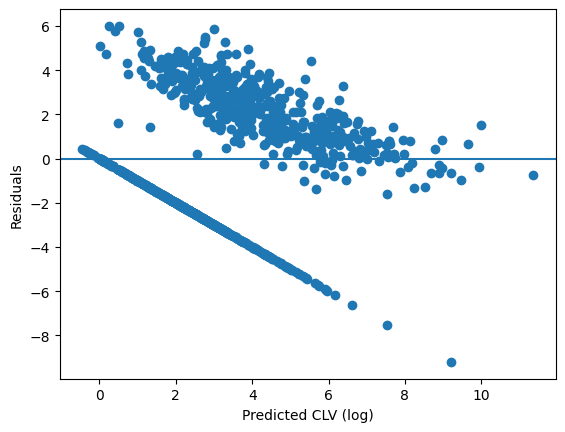

In [68]:
residuals = y_test - y_pred

import matplotlib.pyplot as plt
plt.scatter(y_pred, residuals)
plt.axhline(0)
plt.xlabel("Predicted CLV (log)")
plt.ylabel("Residuals")
plt.show()

#### Ridge Regression

In [69]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)   # alpha = regularization strength
ridge.fit(X_train_scaled, y_train)

Ridge()

In [70]:
y_pred_ridge = ridge.predict(X_test_scaled)

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2 = r2_score(y_test, y_pred_ridge)

mae, rmse, r2

(2.3234372120521254, 2.696888416698915, 0.3515726254752265)

In [72]:
from sklearn.model_selection import GridSearchCV

alphas = {'alpha': [0.01, 0.1, 1, 10, 50, 100]}

ridge_cv = GridSearchCV(
    Ridge(),
    param_grid=alphas,
    scoring='neg_root_mean_squared_error',
    cv=5
)

ridge_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [73]:
ridge_cv.best_params_

{'alpha': 10}

In [74]:
best_ridge = ridge_cv.best_estimator_

In [75]:
y_pred_best = best_ridge.predict(X_test_scaled)

evaluate(y_test, y_pred_best)

{'MAE': 2.324834782937155,
 'RMSE': 2.6971723951785624,
 'R2': 0.3514360613417996}

In [76]:
ridge_coeffs = pd.Series(
    best_ridge.coef_,
    index=features
).sort_values(ascending=False)

ridge_coeffs

Tenure              0.979923
Frequency           0.494261
AOV                 0.448720
Monetary           -0.000941
PurchaseInterval   -0.489810
Recency            -0.951830
dtype: float64

#### ElasticNet

In [77]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
enet.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.01, random_state=42)

In [78]:
y_pred_enet = enet.predict(X_test_scaled)

In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

enet_cv = GridSearchCV(
    ElasticNet(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5
)

enet_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=42),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
             scoring='neg_root_mean_squared_error')

In [80]:
enet_cv.best_params_

{'alpha': 0.01, 'l1_ratio': 0.9}

In [81]:
best_enet = enet_cv.best_estimator_

In [82]:
y_pred_best = best_enet.predict(X_test_scaled)

evaluate(y_test, y_pred_best)

{'MAE': 2.3297465818738723, 'RMSE': 2.698397542720278, 'R2': 0.350846727874915}

In [83]:
enet_coeffs = pd.Series(
    best_enet.coef_,
    index=features
).sort_values(ascending=False)

enet_coeffs

Tenure              0.942879
Frequency           0.512624
AOV                 0.441553
Monetary            0.000000
PurchaseInterval   -0.457449
Recency            -0.947953
dtype: float64

#### Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_base.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [85]:
y_pred_base = rf_base.predict(X_test)

evaluate(y_test, y_pred_base)

{'MAE': 2.1785081532369515,
 'RMSE': 2.7436785921108555,
 'R2': 0.32887741461324616}

In [86]:
rf_controlled = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_controlled.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=10,
                      n_estimators=300, n_jobs=-1, random_state=42)

In [87]:
y_pred_ctrl = rf_controlled.predict(X_test)

evaluate(y_test, y_pred_ctrl)

{'MAE': 2.188537009302862,
 'RMSE': 2.6070992064157172,
 'R2': 0.3940308704972286}

In [88]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 0.7, 0.9]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42
)

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [8, 10, 12, 15],
                                        'max_features': ['sqrt', 0.7, 0.9],
                                        'min_samples_leaf': [5, 10, 20],
                                        'n_estimators': [200, 300, 500]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [89]:
rf_best = rf_random.best_estimator_

In [90]:
y_pred_best = rf_best.predict(X_test)

evaluate(y_test, y_pred_best)

{'MAE': 2.209022961273381,
 'RMSE': 2.6098386497685437,
 'R2': 0.3927567415783606}

In [91]:
feature_importance = pd.Series(
    rf_best.feature_importances_,
    index=features
).sort_values(ascending=False)

feature_importance

Monetary            0.315985
Recency             0.243291
Frequency           0.184106
Tenure              0.117035
PurchaseInterval    0.082504
AOV                 0.057078
dtype: float64

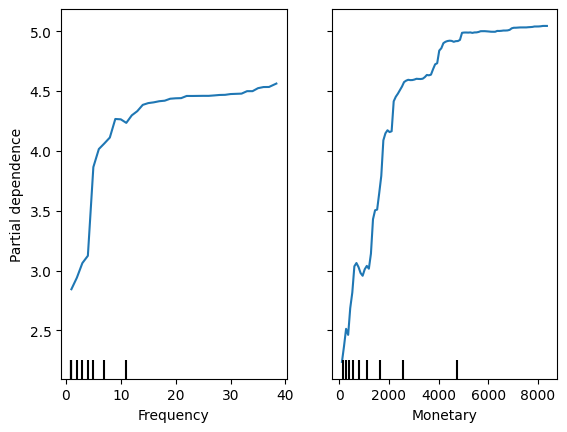

In [92]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    rf_best,
    X_train,
    ['Frequency', 'Monetary']
)

rf_best.score(X_train, y_train), rf_best.score(X_test, y_test)

#### XGBoost

In [93]:
from xgboost import XGBRegressor

# baseline

xgb_base = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_base.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [94]:
y_pred_base = xgb_base.predict(X_test)
evaluate(y_test, y_pred_base)


{'MAE': 2.1844018154176923,
 'RMSE': 2.7699095573299455,
 'R2': 0.31598352407231733}

In [95]:
# control overfitting

xgb_controlled = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,        # L1 regularization
    reg_lambda=1,       # L2 regularization
    objective='reg:squarederror',
    random_state=42
)

xgb_controlled.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [96]:
y_pred_ctrl = xgb_controlled.predict(X_test)
evaluate(y_test, y_pred_ctrl)


{'MAE': 2.1649581610112065,
 'RMSE': 2.6654590561868776,
 'R2': 0.3665980199245925}

In [97]:
# hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_random = RandomizedSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [300, 500, 800],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring='neg_root_mean_squared_error')

In [98]:
xgb_best = xgb_random.best_estimator_

In [99]:
y_pred_best = xgb_best.predict(X_test)
evaluate(y_test, y_pred_best)

{'MAE': 2.192976485108587,
 'RMSE': 2.591042704121165,
 'R2': 0.40147192460494385}

In [100]:
xgb_importance = pd.Series(
    xgb_best.feature_importances_,
    index=features
).sort_values(ascending=False)

xgb_importance

Monetary            0.358663
Frequency           0.270333
Recency             0.212557
Tenure              0.060646
PurchaseInterval    0.058779
AOV                 0.039022
dtype: float32

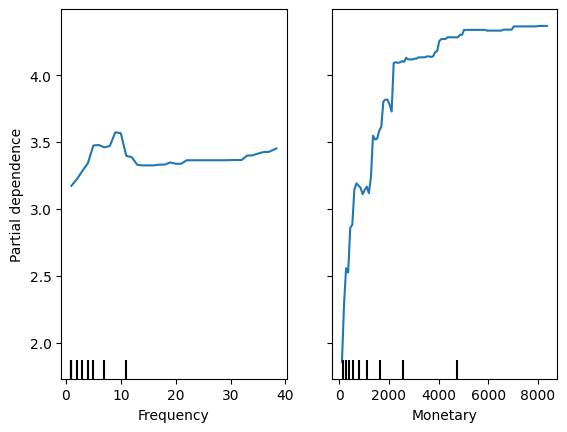

In [101]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    xgb_best,
    X_train,
    ['Frequency', 'Monetary']
)

#### Model Comparision

In [103]:
def evaluate_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

In [104]:
# Linear
y_pred_lr = lr.predict(X_test_scaled)

# Ridge (best / tuned)
y_pred_ridge = best_ridge.predict(X_test_scaled)

# ElasticNet (best / tuned)
y_pred_enet = best_enet.predict(X_test_scaled)

# Random Forest (controlled or best)
y_pred_rf = rf_best.predict(X_test)

# XGBoost (best / early stopping)
y_pred_xgb = xgb_best.predict(X_test)


In [105]:
results = pd.DataFrame([
    {"Model": "Linear Regression", **evaluate_model(y_test, y_pred_lr)},
    {"Model": "Ridge Regression", **evaluate_model(y_test, y_pred_ridge)},
    {"Model": "ElasticNet", **evaluate_model(y_test, y_pred_enet)},
    {"Model": "Random Forest", **evaluate_model(y_test, y_pred_rf)},
    {"Model": "XGBoost", **evaluate_model(y_test, y_pred_xgb)}
])

results.sort_values(by="RMSE")

,Model,MAE,RMSE,R2
4,XGBoost,2.192976,2.591043,0.401472
3,Random Forest,2.209023,2.609839,0.392757
0,Linear Regression,2.323280,2.696857,0.351588
1,Ridge Regression,2.324835,2.697172,0.351436
2,ElasticNet,2.329747,2.698398,0.350847


In [106]:
# Convert Metrics Back to CLV Scale

results["MAE_CLV"] = np.expm1(results["MAE"])
results["RMSE_CLV"] = np.expm1(results["RMSE"])

results

,Model,MAE,RMSE,R2,MAE_CLV,RMSE_CLV
0,Linear Regression,2.323280,2.696857,0.351588,9.209107,13.833040
1,Ridge Regression,2.324835,2.697172,0.351436,9.224991,13.837717
2,ElasticNet,2.329747,2.698398,0.350847,9.275337,13.855907
3,Random Forest,2.209023,2.609839,0.392757,8.106814,12.596857
4,XGBoost,2.192976,2.591043,0.401472,7.961848,12.343678


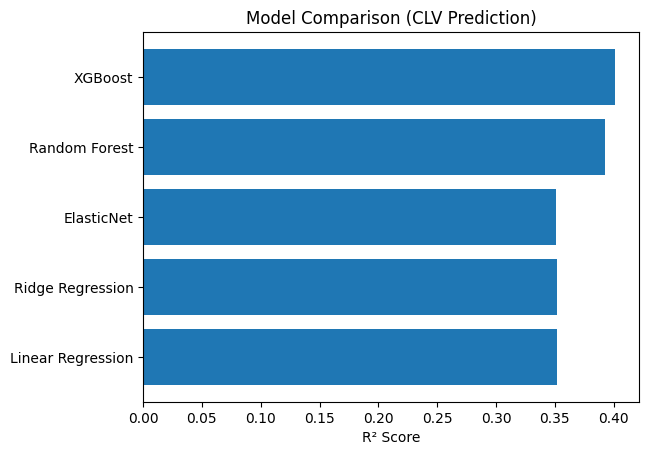

In [107]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(results["Model"], results["R2"])
plt.xlabel("R² Score")
plt.title("Model Comparison (CLV Prediction)")
plt.show()

In [108]:
best_model = results.sort_values("RMSE").iloc[0]
best_model

Model         XGBoost
MAE          2.192976
RMSE         2.591043
R2           0.401472
MAE_CLV      7.961848
RMSE_CLV    12.343678
Name: 4, dtype: object

#### Convert Predictions Back to Real CLV

In [109]:
clv_pred_real = np.expm1(y_pred_xgb)
clv_actual_real = np.expm1(y_test)

In [110]:
# Create default segment

rfm_test = X_test.copy()
rfm_test['Predicted_CLV'] = clv_pred_real

In [111]:
rfm_test['Segment'] = 'Low'

non_zero_mask = rfm_test['Predicted_CLV'] > 0

rfm_test.loc[non_zero_mask, 'Segment'] = pd.qcut(
    rfm_test.loc[non_zero_mask, 'Predicted_CLV'],
    q=[0, 0.33, 0.66, 1.0],
    labels=['Medium', 'High', 'VIP']
)

In [112]:
rfm_test['Segment'].value_counts()

Segment
VIP       338
High      328
Medium    328
Name: count, dtype: int64

In [113]:
rfm_test.groupby('Segment')['Predicted_CLV'].mean()

Segment
High       18.858322
Medium      3.038007
VIP       681.236206
Name: Predicted_CLV, dtype: float32

In [114]:
rfm_test.groupby('Segment')['Predicted_CLV'].describe()

,count,mean,std,min,25%,50%,75%,max
Segment,,,,,,,,
High,328.0,18.858322,9.870260,6.791018,10.401522,16.900577,24.749937,44.304840
Medium,328.0,3.038007,1.901630,0.328428,1.296494,2.809809,4.908077,6.658403
VIP,338.0,681.236206,1233.023071,44.750355,97.085093,227.845093,720.029663,13135.269531


In [115]:
rfm_test.groupby('Segment')['Predicted_CLV'].sum() / rfm_test['Predicted_CLV'].sum()

Segment
High      0.026051
Medium    0.004197
VIP       0.969752
Name: Predicted_CLV, dtype: float32

Using predicted CLV, I segmented customers into Medium, High, and VIP groups. The VIP segment contributed ~97% of predicted revenue, validating the model’s usefulness for targeted retention and marketing strategies.

### SHAP Explainability for XGBoost

In [116]:
import shap

In [117]:
# Create SHAP Explainer
explainer = shap.TreeExplainer(xgb_best)

In [118]:
# Compute SHAP Values

X_sample = X_train.sample(500, random_state=42)

shap_values = explainer.shap_values(X_sample)

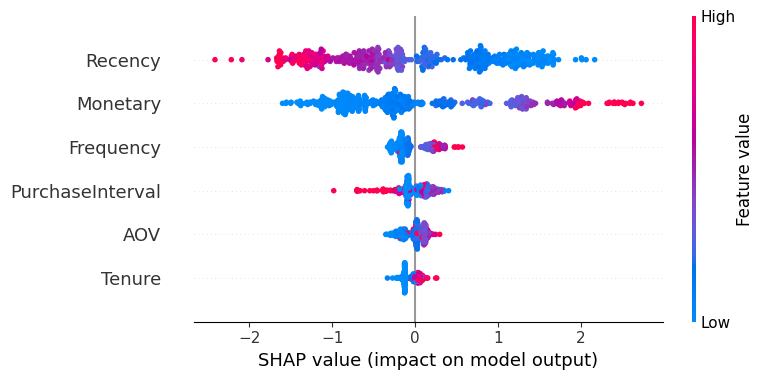

In [119]:
shap.summary_plot(shap_values, X_sample)

In [120]:
shap_importance = np.abs(shap_values).mean(axis=0)

shap_importance_df = (
    pd.DataFrame({
        'Feature': X_sample.columns,
        'Mean_SHAP_Value': shap_importance
    })
    .sort_values(by='Mean_SHAP_Value', ascending=False)
)

shap_importance_df

,Feature,Mean_SHAP_Value
0,Recency,0.885605
2,Monetary,0.844466
1,Frequency,0.188441
5,PurchaseInterval,0.142331
3,AOV,0.101359
4,Tenure,0.076839


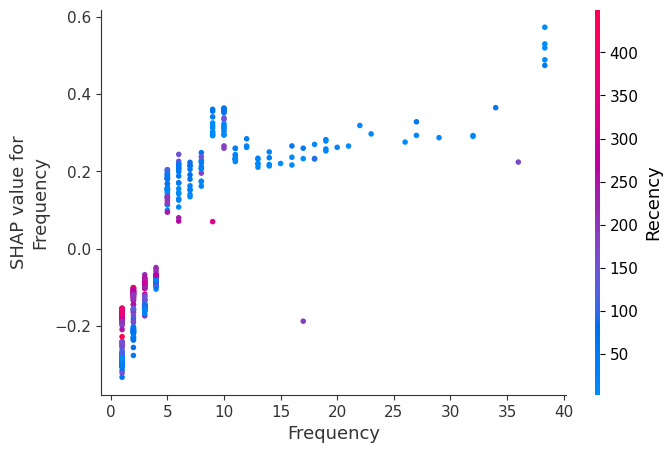

In [121]:
shap.dependence_plot(
    'Frequency',
    shap_values,
    X_sample
)

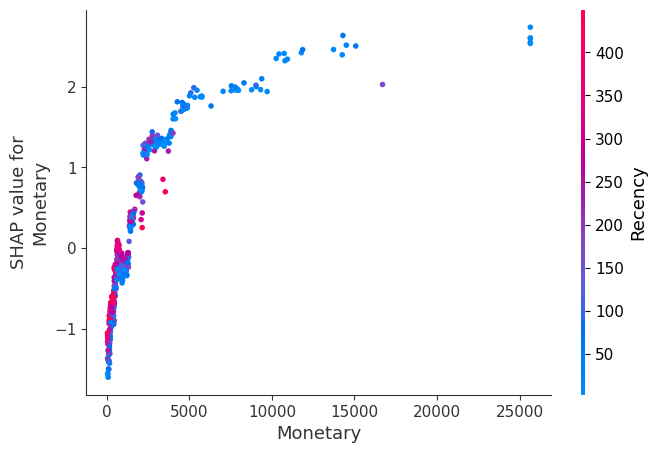

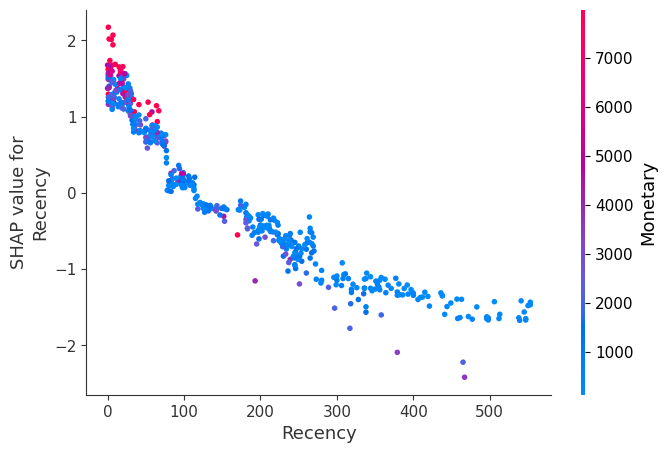

In [122]:
shap.dependence_plot('Monetary', shap_values, X_sample)
shap.dependence_plot('Recency', shap_values, X_sample)

In [123]:
vip_idx = rfm_test[rfm_test['Segment'] == 'VIP'].index[0]

In [124]:
X_vip = X_test.loc[[vip_idx]]

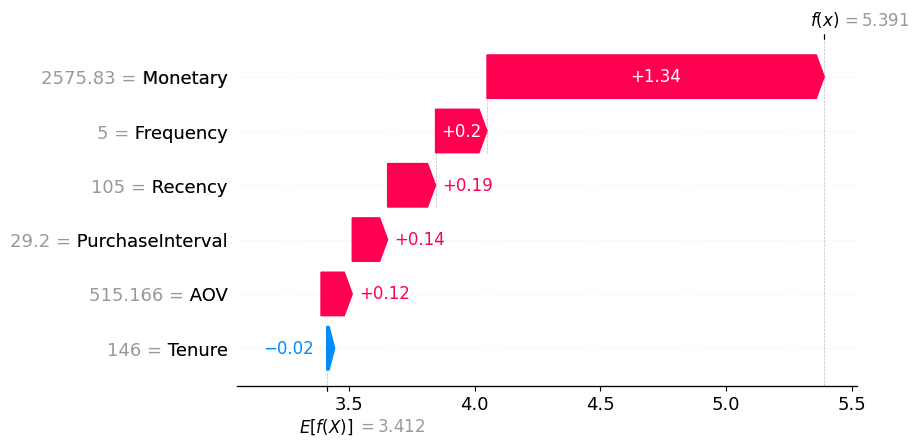

In [125]:
shap.waterfall_plot(
    shap.Explanation(
        values=explainer.shap_values(X_vip)[0],
        base_values=explainer.expected_value,
        data=X_vip.iloc[0],
        feature_names=X_vip.columns
    )
)

In [126]:
rfm_test['Predicted_log_CLV'] = y_pred_xgb

vip_mask = rfm_test['Segment'] == 'VIP'
non_vip_mask = rfm_test['Segment'] != 'VIP'

shap_vip = explainer.shap_values(X_test[vip_mask])
shap_non_vip = explainer.shap_values(X_test[non_vip_mask])

np.abs(shap_vip).mean(axis=0) - np.abs(shap_non_vip).mean(axis=0)

array([ 0.20806062,  0.05028167,  0.5118489 , -0.01042695, -0.03627723,
        0.04929596], dtype=float32)

### Save the Model

In [127]:
import joblib

joblib.dump(xgb_best, "clv_xgboost_model.pkl")  # Save Model

['clv_xgboost_model.pkl']

In [128]:
joblib.dump(features, "clv_model_features.pkl")  # Save Feature List

['clv_model_features.pkl']

### Load the model for prediction

In [137]:
import joblib
import numpy as np
import pandas as pd

# Load model & feature list
model = joblib.load("clv_xgboost_model.pkl")
features = joblib.load("clv_model_features.pkl")

# Sample input (change values if you want)
input_data = pd.DataFrame([{
    "Recency": 10,
    "Frequency": 15,
    "Monetary": 8000,
    "AOV": 500,
    "Tenure": 400,
    "PurchaseInterval": 25
}])

# Ensure correct feature order
input_data = input_data[features]

# Predict (log scale)
clv_log = model.predict(input_data)

# Convert back to real CLV
clv_real = np.expm1(clv_log)

print("Predicted 6-Month CLV :", round(clv_real[0], 2))

Predicted 6-Month CLV : 1769.89


In [129]:
import joblib
import numpy as np
import pandas as pd

# Load model and features
model = joblib.load("clv_xgboost_model.pkl")
model_features = joblib.load("clv_model_features.pkl")

In [130]:
new_customers = pd.DataFrame({
    'Recency': [10, 120, 300],
    'Frequency': [15, 3, 1],
    'Monetary': [8000, 1200, 300],
    'AOV': [533, 400, 300],
    'Tenure': [400, 90, 30],
    'PurchaseInterval': [26, 30, 30]
})

In [131]:
new_customers = new_customers[model_features]   # Align Feature Order

In [132]:
# make predictions on log scale
clv_pred_log = model.predict(new_customers)

In [133]:
# convert back to real CLV
clv_pred_real = np.expm1(clv_pred_log)
clv_pred_real

array([1757.6772  ,   21.25655 ,    2.703932], dtype=float32)

In [134]:
output = new_customers.copy()
output['Predicted_6M_CLV'] = clv_pred_real

output

,Recency,Frequency,Monetary,AOV,Tenure,PurchaseInterval,Predicted_6M_CLV
0,10,15,8000,533,400,26,1757.677246
1,120,3,1200,400,90,30,21.256550
2,300,1,300,300,30,30,2.703932


In [135]:
# Segment new customers

output['Segment'] = 'Low'

non_zero_mask = output['Predicted_6M_CLV'] > 0
output.loc[non_zero_mask, 'Segment'] = pd.qcut(
    output.loc[non_zero_mask, 'Predicted_6M_CLV'],
    q=[0, 0.33, 0.66, 1.0],
    labels=['Medium', 'High', 'VIP']
)

output

,Recency,Frequency,Monetary,AOV,Tenure,PurchaseInterval,Predicted_6M_CLV,Segment
0,10,15,8000,533,400,26,1757.677246,VIP
1,120,3,1200,400,90,30,21.256550,High
2,300,1,300,300,30,30,2.703932,Medium
